In [2]:
import pandas as pd
import numpy as np
import jieba

In [3]:
data=pd.read_csv(r'F:\Test\2019-Dec.csv')

### 总观数据

In [4]:
print(data.head())
print(data.shape)
print(data.info())

                event_time        event_type  product_id          category_id  \
0  2019-12-01 00:00:00 UTC  remove_from_cart     5712790  1487580005268456287   
1  2019-12-01 00:00:00 UTC              view     5764655  1487580005411062629   
2  2019-12-01 00:00:02 UTC              cart        4958  1487580009471148064   
3  2019-12-01 00:00:05 UTC              view     5848413  1487580007675986893   
4  2019-12-01 00:00:07 UTC              view     5824148  1487580005511725929   

  category_code      brand  price    user_id  \
0           NaN      f.o.x   6.27  576802932   
1           NaN        cnd  29.05  412120092   
2           NaN     runail   1.19  494077766   
3           NaN  freedecor   0.79  348405118   
4           NaN        NaN   5.56  576005683   

                           user_session  
0  51d85cb0-897f-48d2-918b-ad63965c12dc  
1  8adff31e-2051-4894-9758-224bfa8aec18  
2  c99a50e8-2fac-4c4d-89ec-41c05f114554  
3  722ffea5-73c0-4924-8e8f-371ff8031af4  
4  28172809-7e

### 统计各维度的基本流量指标

In [5]:
total_uv=data['user_id'].value_counts()
print(total_uv)
total_uv=len(total_uv)
print('total_uv='+str(total_uv))
total_pv=len(data['user_id'])
print('total_pv='+str(total_pv))

527021202    8689
572631412    3883
467810091    3147
548810441    2426
584289031    2356
             ... 
417569132       1
593717618       1
589513079       1
475918839       1
569728340       1
Name: user_id, Length: 370154, dtype: int64
total_uv=370154
total_pv=3533286


In [6]:
data.isnull().any()

event_time       False
event_type       False
product_id       False
category_id      False
category_code     True
brand             True
price            False
user_id          False
user_session      True
dtype: bool

In [7]:
pd.set_option('display.float_format',lambda x:'%.3f' %x)
data['price'].describe()

count   3533286.000
mean          8.872
std          19.865
min         -79.370
25%           2.060
50%           4.210
75%           7.140
max         327.780
Name: price, dtype: float64

In [8]:
#删除无效列
data.drop('category_code',axis=1,inplace=True)

In [9]:
#总成交额/gmv（不考虑退货退款）
total_gmv=data['price'].sum()
print('total_gmv='+str('%.2f'%total_gmv))

total_gmv=31346804.92


In [10]:
#总成交量
total_order=len(data[data.event_type=='purchase']['user_session'].value_counts())
print('total_order='+str(total_order))

total_order=28894


In [11]:
#购买行为分类统计
user_event_count=data['event_type'].value_counts()
print(user_event_count)
print(type(user_event_count))

view                1728331
cart                 927124
remove_from_cart     664655
purchase             213176
Name: event_type, dtype: int64
<class 'pandas.core.series.Series'>


In [12]:
#成交率
paid_user=data[data.event_type=='purchase'].nunique()['user_id']
print('paid_user='+str('%.0f'%paid_user))
total_paid_rate=(paid_user/total_uv)*100
print('total_paid_rate='+str('%.2f'%total_paid_rate)+'%')

paid_user=25613
total_paid_rate=6.92%


In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

Text(0.5, 1.0, 'user_buy_time')

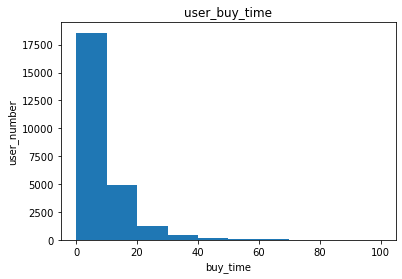

In [14]:
#用户购买次数分布
user_buy_time=data[data.event_type=='purchase'].groupby('user_id').count()['product_id'] #output Series
plt.hist(x=user_buy_time,bins=10,range=[0,100])
plt.xlabel('buy_time')
plt.ylabel('user_number')
plt.title('user_buy_time')

In [15]:
#人均购买次数
total_buy_time=data[data.event_type=='purchase'].count()['user_id']
per_user_buy_time=total_buy_time/paid_user
print('per_user_buy_time='+str('%.2f'%per_user_buy_time))

per_user_buy_time=8.32


In [16]:
#复购率（购买次数在2次及以上的人数/有过购买记录的人数）
twice_buy_user=user_buy_time[user_buy_time>2].count()
twice_buy_user
rebuy_rate=(twice_buy_user/paid_user)*100
print('rebuy_rate='+str('%.2f'%rebuy_rate)+'%')
# print("复购率:{:.2f}%".format(repurchase_rate*100))

rebuy_rate=77.27%


## 小结:总体流量指标诊断

* 取前1w行进行预分析，总体指标情况如下：total_uv=1450，total_pv=~~10000~~，max_price=327.78，total_gmv=84519.37，total_order=59，total_paid_rate=4.07%，per_user_buy_time=11.47，rebuy_rate=91.53%
* 用户购买次数分布显示，大多分布在0-10次区间内；10-20次区间内的用户价值有待进一步挖掘；30次以上的用户可被认定为“忠诚会员”提供1V1服务
* 复购率高达91.53%，人均购买11.47次，说明该平台用户忠诚度较高

(以上是1w条测试数据时的结论）

* 总353w+条记录，总体指标情况如下：
total_uv=370154，
total_pv=~~3533286~~（1728331），
max_price=327.78，
total_gmv=31346804.92，
total_order=28894，
paid_user=25613而amount of purchase=213176
total_paid_rate=6.92%，
per_user_buy_time=8.32，
rebuy_rate=77.27%
* 用户购买次数分布显示，大多分布在0-10次区间内；10-20次区间内的用户价值有待进一步挖掘；30次以上的用户可被认定为“忠诚会员”提供1V1服务
* 复购率高达91.53%，人均购买11.47次，说明该平台用户忠诚度较高

In [17]:
#跳失率:只有点击行为的人数/总用户数total_uv
# user_view_time=data[data.event_type=='view'].groupby('user_id').count()['product_id']
# dict_user_view_time={'user_id':user_view_time.index,'times':user_view_time.values}
# total_uv=data['user_id'].value_counts()
# dict_total_uv={'user_id':total_uv.index,'times':total_uv.values}
# print(dict_user_view_time,dict_total_uv)
# only_view_user=pd.Series(list(set(user_view_time).index.intersection(set(total_uv).index)))
#series.value_counts()[0]（最高的频数） or series.value_counts().index[0]（频数最高的键）
# only_view_user=[]
# for i in dict_user_view_time.keys():
#     if i in dict_total_uv.keys():
#         only_view_user.append(i)
#     else:
#         break
# print(only_view_user)
# print(user_view_time,user_event_time)
# # 计算跳失率
# bounce_rate=only_pv_user.shape[0]/total_unique_users
# print("跳失率:{:.2f}%".format(bounce_rate*100))

In [18]:
data.nunique()

event_time      1654771
event_type            4
product_id        44624
category_id         482
brand               252
price              2122
user_id          370154
user_session     839812
dtype: int64

### 用户行为日分布

In [19]:
date=[]
hour=[]

for i in range(0,3533286):
    split_time=str(data['event_time'][i]).split(' ')
    for a in split_time:
        if "-" in a:
            date.append(a)
        elif ":" in a:
            hour.append(a)
#print(date,hour)

In [20]:
data['date']=date
data['hour']=hour
# del data['event_time']
print(data['date'].tail(10))

3533276    2019-12-31
3533277    2019-12-31
3533278    2019-12-31
3533279    2019-12-31
3533280    2019-12-31
3533281    2019-12-31
3533282    2019-12-31
3533283    2019-12-31
3533284    2019-12-31
3533285    2019-12-31
Name: date, dtype: object


In [21]:
# 日流量指标
daily_pv=data[data.event_type=='view'].groupby('date')['user_id'].count().reset_index().rename(columns={'user_id':'pv'})
daily_uv=data.groupby('date').nunique()['user_id'].reset_index().rename(columns={'user_id':'uv'})
print(daily_pv,'\n',daily_uv)

          date     pv
0   2019-12-01  59528
1   2019-12-02  64921
2   2019-12-03  63503
3   2019-12-04  65472
4   2019-12-05  61445
5   2019-12-06  56883
6   2019-12-07  53910
7   2019-12-08  57435
8   2019-12-09  73983
9   2019-12-10  68677
10  2019-12-11  69931
11  2019-12-12  65577
12  2019-12-13  59932
13  2019-12-14  53099
14  2019-12-15  60275
15  2019-12-16  67282
16  2019-12-17  63779
17  2019-12-18  64313
18  2019-12-19  58848
19  2019-12-20  49265
20  2019-12-21  49525
21  2019-12-22  52169
22  2019-12-23  58344
23  2019-12-24  54577
24  2019-12-25  54129
25  2019-12-26  46670
26  2019-12-27  41300
27  2019-12-28  41477
28  2019-12-29  40668
29  2019-12-30  34198
30  2019-12-31  17216 
           date     uv
0   2019-12-01  17540
1   2019-12-02  19391
2   2019-12-03  18735
3   2019-12-04  18836
4   2019-12-05  18183
5   2019-12-06  16948
6   2019-12-07  15508
7   2019-12-08  16835
8   2019-12-09  19777
9   2019-12-10  19336
10  2019-12-11  20128
11  2019-12-12  18920
12  2019

Text(0.5, 1.0, 'daily_uv')

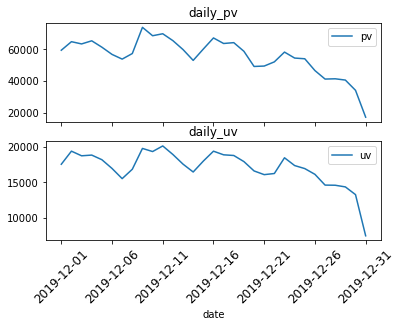

In [22]:
ax1=plt.subplot(2,1,1,label='daily_pv')
ax2=plt.subplot(212,sharex=ax1,label='daily_uv')
# fig,axes=plt.subplots(2,1,1,figsize=(12,8),sharex='all')
daily_pv.plot(x='date',y='pv',ax=ax1)
daily_uv.plot(x='date',y='uv',ax=ax2)
plt.xticks(rotation=45,fontsize=12)
ax1.set_title('daily_pv')
ax2.set_title('daily_uv')

### 用户行为时分布

In [42]:
#小时流量指标
# for i in data.columns[:2]:
#     data[i]=data[i].astype('str')
# data['date']=pd.to_datetime(data.date)
# data['hour']=data.hour.astype('int')
hour_int=[]
for i in hour:
    hour_int.append(i[0:2])
# print(hour_int[:10])

['00', '00', '00', '00', '00', '00', '00', '00', '00', '00']


In [46]:
data['hour_int']=hour_int
pv_hour=data[data.event_type=='view'].groupby('hour_int').count()['user_id'].reset_index(drop=True)
uv_hour.columns=['hour','pv']
uv_hour=data.groupby('hour_int').nunique()['user_id'].reset_index(drop=True)   # .rename(columns={'user_id':'uv'})一直显示rename有个unexpected keyword kwarg columns
uv_hour.columns=['hour','uv']
print(pv_hour,'\n',uv_hour)

0      17823
1      14194
2      15270
3      21451
4      32463
5      48661
6      65981
7      79501
8      88832
9      93496
10     98463
11    101215
12    101922
13    101012
14     93500
15     90756
16     92337
17     96901
18    105415
19    115898
20    106216
21     76067
22     45477
23     25480
Name: user_id, dtype: int64 
 0      5638
1      5279
2      5982
3      8871
4     13098
5     18922
6     25080
7     29893
8     32771
9     34345
10    35426
11    36498
12    37048
13    35988
14    34131
15    33544
16    33645
17    34957
18    36419
19    36793
20    31668
21    21290
22    13018
23     8062
Name: user_id, dtype: int64


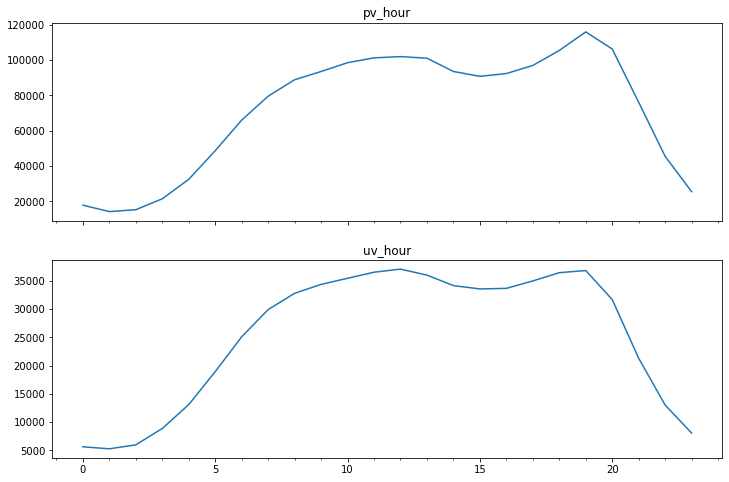

In [49]:
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(12,8),sharex=True)
pv_hour.plot(ax=axes[0])
uv_hour.plot(ax=axes[1])
axes[0].set_title('pv_hour')
axes[1].set_title('uv_hour')
axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
axes[1].xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()

In [50]:
mean_daily_pv=data[data.event_type=='view'].groupby('date')['user_id'].count().mean()
print('mean_daily_pv='+str('%.2f'%mean_daily_pv))
mean_daily_uv=data.groupby('date').nunique()['user_id'].mean()
print('mean_daily_uv='+str('%.2f'%mean_daily_uv))
mean_daily_gmv=data.groupby('date')['price'].sum().mean()
print('mean_daily_gmv='+str('%.2f'%mean_daily_gmv))
mean_daily_order=data[data.event_type=='purchase'].groupby('date').nunique()['user_session'].values.mean() #series.values访问频数，.index访问索引
print('mean_daily_order='+str('%.0f'%mean_daily_order))
mean_daily_paid_user=data[data.event_type=='purchase'].groupby('date').nunique()['user_id'].mean()
print('mean_daily_paid_user='+str('%.0f'%mean_daily_paid_user))
mean_daily_paid_rate=(mean_daily_paid_user/mean_daily_uv)*100
print('mean_daily_paid_rate='+str('%.2f'%mean_daily_paid_rate)+'%')
mean_daily_ARPU=(mean_daily_gmv/mean_daily_uv)
print('mean_daily_ARPU='+str('%.2f'%mean_daily_ARPU))
mean_daily_ARPPU=(mean_daily_gmv/mean_daily_paid_user)
print('mean_daily_ARPPU='+str('%.2f'%mean_daily_ARPPU))

mean_daily_pv=55752.61
mean_daily_uv=17065.32
mean_daily_gmv=1011187.26
mean_daily_order=934
mean_daily_paid_user=919
mean_daily_paid_rate=5.39%
mean_daily_ARPU=59.25
mean_daily_ARPPU=1100.31


## 小结：用户消费行为总览
* 总体指标概览
mean_daily_pv=10000.00
mean_daily_uv=1450.00
mean_daily_gmv=84519.37
mean_daily_order=59
mean_daily_paid_user=59
mean_daily_paid_rate=4.07%
mean_daily_ARPU=58.29
mean_daily_ARPPU=1432.53

-------
（以上是1w条预分析的结论）
* 总体指标概览 :joy:
mean_daily_pv=55752.61
mean_daily_uv=17065.32
mean_daily_gmv=1011187.26
mean_daily_order=934
mean_daily_paid_user=919
mean_daily_paid_rate=5.39%
mean_daily_ARPU=59.25
mean_daily_ARPPU=1100.31
* 从daily_pv&daily_uv图表可以看出，该月内用户量、访问量几乎同幅变动，整体呈现逐渐下降的趋势，在12.2、12.9两个预售日节点有明显小高峰，12.12活动当天达到峰值，紧接着有2-3天的冷却期，之后12.16、12.23有返潮现象
* 周末活跃度明显高于其它工作日，故营销活动或宣发应在周末进行
* 从pv_hour&uv_hour图表可以看出，总体来看19:00-次日2:00的访问量在下降，2:00后开始回升,7:00至正常水平，每日的12:00、19:00达到峰值，反映出午餐及下班后时间更适宜搞平台运营动作
* 用户活跃时段9:00-13:00、17:00-20:00，一般活跃时段13:00-17:00、5:00-9:00，,非活跃时段20:00-5:00

In [51]:
view=data[data.event_type=='view']
cart=data[data.event_type=='cart']
purchase=data[data.event_type=='purchase']
remove=data[data.event_type=='remove from cart']

In [52]:
view_num=view.user_id.nunique()
cart_num=cart.user_id.nunique()
purchase_num=purchase.user_id.nunique()
remove_num=remove.user_id.nunique()
view_num

358212

### 画用户行为漏斗图

In [72]:
!pip install -U pyecharts

  Using cached pyecharts-1.9.0-py3-none-any.whl (135 kB)
  Attempting uninstall: pyecharts
    Found existing installation: pyecharts 0.1.9.4
    Uninstalling pyecharts-0.1.9.4:
      Successfully uninstalled pyecharts-0.1.9.4


In [73]:
from pyecharts.charts import Funnel
from pyecharts import options as opts

In [80]:
funnel_data=[("浏览",view_num),("加购",cart_num),("付费",purchase_num)]
(Funnel(init_opts=opts.InitOpts(width='500px',height='300px')).add(
    "type",data_pair=funnel_data,label_opts=opts.LabelOpts(),gap=1,tooltip_opts=opts.TooltipOpts(is_show=True)).set_global_opts(
        title_opts=opts.TitleOpts(title="用户转化漏斗",subtitle="process:浏览-加购-付费"))
).render_notebook()

### 计算用户流转链路中的层级转化率

In [85]:
view2cart=pd.merge(left=view,right=cart,how='inner',on=['user_id','product_id'],suffixes=("_view","_cart"))
cart2purchase=pd.merge(left=cart,right=purchase,how='inner',on=['user_id','product_id'],suffixes=("_cart","_purchase"))
view2purchase=pd.merge(left=view,right=purchase,how='inner',on=['user_id','product_id'],suffixes=("_view","_purchase"))
view2cart

,event_time_view,event_type_view,product_id,category_id_view,brand_view,price_view,user_id,user_session_view,date_view,hour_view,hour_int_view,event_time_cart,event_type_cart,category_id_cart,brand_cart,price_cart,user_session_cart,date_cart,hour_cart,hour_int_cart
0,2019-12-01 00:00:22 UTC,view,5807805,1487580005713052531,ingarden,4.440,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,2019-12-01,00:00:22,00,2019-12-01 00:11:31 UTC,cart,1487580005713052531,ingarden,4.440,28172809-7e4a-45ce-bab0-5efa90117cd5,2019-12-01,00:11:31,00
1,2019-12-01 00:11:20 UTC,view,5807805,1487580005713052531,ingarden,4.440,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,2019-12-01,00:11:20,00,2019-12-01 00:11:31 UTC,cart,1487580005713052531,ingarden,4.440,28172809-7e4a-45ce-bab0-5efa90117cd5,2019-12-01,00:11:31,00
2,2019-12-01 00:00:46 UTC,view,5798929,1783999068909863670,zinger,6.190,579966747,1512be50-d0fd-4a92-bcd8-3ea3943f2a3b,2019-12-01,00:00:46,00,2019-12-01 00:03:32 UTC,cart,1783999068909863670,zinger,6.190,1512be50-d0fd-4a92-bcd8-3ea3943f2a3b,2019-12-01,00:03:32,00
3,2019-12-01 00:02:41 UTC,view,5798929,1783999068909863670,zinger,6.190,579966747,1512be50-d0fd-4a92-bcd8-3ea3943f2a3b,2019-12-01,00:02:41,00,2019-12-01 00:03:32 UTC,cart,1783999068909863670,zinger,6.190,1512be50-d0fd-4a92-bcd8-3ea3943f2a3b,2019-12-01,00:03:32,00
4,2019-12-01 00:03:27 UTC,view,5798929,1783999068909863670,zinger,6.190,579966747,1512be50-d0fd-4a92-bcd8-3ea3943f2a3b,2019-12-01,00:03:27,00,2019-12-01 00:03:32 UTC,cart,1783999068909863670,zinger,6.190,1512be50-d0fd-4a92-bcd8-3ea3943f2a3b,2019-12-01,00:03:32,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630238,2019-12-31 23:52:21 UTC,view,5831578,1487580011677352062,NaN,10.950,595413503,3d5af3a2-4a25-48df-b981-b8021915dfe8,2019-12-31,23:52:21,23,2019-12-31 23:53:04 UTC,cart,1487580011677352062,NaN,10.950,3d5af3a2-4a25-48df-b981-b8021915dfe8,2019-12-31,23:53:04,23
630239,2019-12-31 23:52:55 UTC,view,5746400,1487580005754995573,NaN,4.440,420652863,546f6af3-a517-4752-a98b-80c4c5860711,2019-12-31,23:52:55,23,2019-12-10 09:17:52 UTC,cart,1487580005754995573,NaN,4.440,c05dd6c7-0753-4217-83a2-fdbcdb2d566f,2019-12-10,09:17:52,09
630240,2019-12-31 23:52:55 UTC,view,5746400,1487580005754995573,NaN,4.440,420652863,546f6af3-a517-4752-a98b-80c4c5860711,2019-12-31,23:52:55,23,2019-12-31 23:53:31 UTC,cart,1487580005754995573,NaN,4.440,546f6af3-a517-4752-a98b-80c4c5860711,2019-12-31,23:53:31,23
630241,2019-12-31 23:54:02 UTC,view,5809871,1605161575889502297,grattol,3.020,502631750,6edb4c0e-285c-4fbc-8977-589ef6d326b8,2019-12-31,23:54:02,23,2019-12-31 23:54:25 UTC,cart,1605161575889502297,grattol,3.020,6edb4c0e-285c-4fbc-8977-589ef6d326b8,2019-12-31,23:54:25,23


In [105]:
# view2cart['event_time_view']=pd.toDatetime()
view2cart_user=view2cart[view2cart.event_time_view<view2cart.event_time_cart].user_id.nunique()
cart2purchase_user=cart2purchase[cart2purchase.event_time_cart<cart2purchase.event_time_purchase].user_id.nunique()
view2purchase_user=view2purchase[view2purchase.event_time_view<view2purchase.event_time_purchase].user_id.nunique()
print(view2cart_user,cart2purchase_user,view2purchase_user)
view_user=data[data.event_type=='view'].user_id.nunique()
cart_user=data[data.event_type=='cart'].user_id.nunique()
# 计算层级转化率
view2cart_rate=view2cart_user/view_user
cart2purchase_rate=cart2purchase_user/cart_user
view2purchase_rate=view2purchase_user/view_user
print('浏览加购层级转化率%.2f%%'%(view2cart_rate*100))
print('加购付费层级转化率%.2f%%'%(cart2purchase_rate*100))
print('浏览付费层级转化率%.2f%%'%(view2purchase_rate*100))

52979 25176 21279
浏览加购层级转化率14.79%
加购付费层级转化率30.17%
浏览付费层级转化率5.94%


In [101]:
print(user_event_count)

view                1728331
cart                 927124
remove_from_cart     664655
purchase             213176
Name: event_type, dtype: int64


### 计算用户流转链路中的总转化率

In [110]:
# 计算总转化率（即默认用户先浏览后加购后购买）
purchase_user=data[data.event_type=='purchase'].user_id.nunique()
remove_user=data[data.event_type=='remove_from_cart'].user_id.nunique()
print('浏览后加购率%.2f%%'%((cart_user/view_user)*100))
print('加购后付费率%.2f%%'%((purchase_user/cart_user)*100))
print('加购后移除率%.2f%%'%((remove_user/cart_user)*100))
print('总uv中浏览人占比%.2f%%'%((view_user/total_uv)*100))
print('总uv中加购人占比%.2f%%'%((cart_user/total_uv)*100))
print('总uv中购买人占比%.2f%%'%((purchase_user/total_uv)*100))

浏览后加购率23.30%
加购后付费率30.69%
加购后移除率54.18%
总uv中浏览人占比96.77%
总uv中加购人占比22.55%
总uv中购买人占比6.92%


## 小结：用户转化漏斗分析
* ps此处的处理方式是由于①并未能保证用户均是按照理想链路流转，因此不能直接除以，需要合并求交叉值，并控制时间先后才能确保结果是我们所需的“精准”的流转链路。
* 进一步释义：合并后的记录有630243条，这意味着有（927124-630243）位用户是未浏览详情页直接加购的，view2cart_user=52979，有（630243-52979）位用户不是在周期内形成view→cart完整链路的。
* 层级转化率：浏览的人中有14.79%加购，加购的人中有30.17%付费，浏览的人中有5.94%直接付费。
* 总转化率中用“模糊”形式得到了23.30%和30.69%，相对来说都是偏大的。
* 总活跃用户中各种行为的uid占比，结合前方的层级转化可见，大部分用户还是停留在浏览的一个阶段，需要运营在该转化节点加力。对应举措（1）运营多多筹办积分活动、会员活动、促销活动等促使用户尽快加购付费；（2）用户增长可以拓展站外流量来源，增加点击量；（3）产品可以增加醒目的加购提醒或降价/秒杀消息通知等。